# Unsupervised Language Learning Lab 1

Tom Scheffers - 11728191 <br>
Stefan Knegt - 11784261

In [63]:
import numpy as np
import scipy
import scipy.stats
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import time
import random

## 2. Getting the pre-trained word vectors

In [64]:
bow2 = {}
with open('bow2.words') as f:
    header = 1
    for line in f:
        if header == 1:
            header = 0
        else:
            word = line.split(' ', 1)[0]
            emb = line.split(' ', 1)[1]
            bow2[word] = emb
            
bow5 = {}
with open('bow5.words') as f:
    header = 1
    for line in f:
        if header == 1:
            header = 0
        else:
            word = line.split(' ', 1)[0]
            emb = line.split(' ', 1)[1]
            bow5[word] = emb
            
dep = {}
with open('deps.words') as f:
    header = 1
    for line in f:
        if header == 1:
            header = 0
        else:
            word = line.split(' ', 1)[0]
            emb = line.split(' ', 1)[1]
            dep[word] = emb
            
for key,value in bow2.items():
    temp_list = value.split()
    temp_list_float = [float(i) for i in temp_list]
    bow2[key] = temp_list_float
    
for key,value in bow5.items():
    temp_list = value.split()
    temp_list_float = [float(i) for i in temp_list]
    bow5[key] = temp_list_float
    
for key,value in dep.items():
    temp_list = value.split()
    temp_list_float = [float(i) for i in temp_list]
    dep[key] = temp_list_float

In [65]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

## 3. Word Similarity Task

In [66]:
simlex_file = './SimLex-999/SimLex-999.txt'
simlex_sim = {}
header = True
with open(simlex_file,'r') as f:
    for line in f:
        if header == True:
            header = False
        else:
            values = line.split('\t')
            simlex_sim[(values[0], values[1])] = float(values[3])

men_file = './MEN/MEN_dataset_natural_form_full'
men_sim = {}
with open(men_file,'r') as g:
    for line in g:
        values = line.split()
        men_sim[(values[0], values[1])] = values[2]


In [67]:
results_spearman = {}
results_pearson = {}

embeddings = {"bow2":bow2,"bow5":bow5,"dep":dep}
sim_dict = {"simlex":simlex_sim,"mensim":men_sim}

#For the three different embedding models and two similarity datasets we get the Pearson and Spearman correlation

for k1,v1 in embeddings.items():
    for k2,v2 in sim_dict.items():
        list1 = []
        list2 = []
        for key,value in v2.items():
            word1 = key[0]
            word2 = key[1]
            try:
                sim = cos_sim(v1[str(word1)],v1[str(word2)])
                list1.append(float(value))
                list2.append(sim)
            except:
                next
        results_spearman[k1+"-"+k2] = scipy.stats.spearmanr(list1,list2)
        results_pearson[k1+"-"+k2] = scipy.stats.pearsonr(list1,list2) 

In [68]:
assert(len(results_pearson)==len(results_spearman))
print(results_pearson)
print('\n')
print(results_spearman)

{'bow2-simlex': (0.42845866181644987, 7.992996652236848e-46), 'bow2-mensim': (0.6776982244699231, 0.0), 'bow5-simlex': (0.37560059706687154, 8.607410572298394e-35), 'bow5-mensim': (0.708236248047157, 0.0), 'dep-simlex': (0.46190134429723584, 6.838935662413016e-54), 'dep-mensim': (0.5974016044666723, 1.0183783114142845e-289)}


{'bow2-simlex': SpearmanrResult(correlation=0.41414576777339385, pvalue=1.226812869252797e-42), 'bow2-mensim': SpearmanrResult(correlation=0.699904755830819, pvalue=0.0), 'bow5-simlex': SpearmanrResult(correlation=0.36739613669787896, pvalue=2.9775781067162087e-33), 'bow5-mensim': SpearmanrResult(correlation=0.7231686561368844, pvalue=0.0), 'dep-simlex': SpearmanrResult(correlation=0.4456409349330385, pvalue=7.414295711467014e-50), 'dep-mensim': SpearmanrResult(correlation=0.6178227900207052, pvalue=2.37026036e-315)}


## 4. Word Analogy Task

In [69]:
analogy_file = 'questions-words.txt'
analogies = []
with open(analogy_file,'r') as h:
    for line in h:
        values = line.split()
        if values[0] != ':':
            analogies.append([values[0], values[1], values[2], values[3]])
print("Total number of analogies: ", len(analogies))

19544


In [74]:
embed_dict_dict = {'bow2':bow2,'bow5':bow5, 'dep':dep}
analogy_pred = {k: [] for k,v in embed_dict_dict.items()}

all_words = [k for k,_ in dep.items()]
all_word_vectors = np.asarray([v for k,v in dep.items()])

sampled_analogies = random.sample(analogies,1)
print("Number of analogies: ", len(sampled_analogies))

for key, embed_dict in embed_dict_dict.items():
    for an in sampled_analogies:
        try:
            a = embed_dict[an[0].lower()]
            a = [(i/np.linalg.norm(a)) for i in a]
            a_star = embed_dict[an[1].lower()]
            a_star = [(i/np.linalg.norm(a_star)) for i in a_star]
            b = embed_dict[an[2].lower()]   
            b = [(i/np.linalg.norm(b)) for i in b]
            b_star = embed_dict[an[3].lower()]
            b_star = [(i/np.linalg.norm(b_star)) for i in b_star]

            v = [astar_i - a_i for astar_i, a_i in zip(a_star, a)]
            b_pred = [b_i + v_i for b_i, v_i in zip(b, v)]
            b_pred = np.asarray(b_pred).reshape((1,-1))

            distances = scipy.spatial.distance.cdist(b_pred, all_word_vectors, metric='cosine')
            predictions = [w for _,w in sorted(zip(list(distances.reshape((-1,1))), all_words))]

            analogy_pred[key].append(predictions.index(an[3].lower()))
        except:
            print(an, " did not appear in embedding dicts")

Number of analogies:  1


In [75]:
mrr_dict = {}
for key, ranks in analogy_pred.items():
    Q = len(ranks)
    mrr = 0
    for r in ranks:
        mrr += 1/r
    mrr_dict[key] = mrr / Q
print(mrr_dict)

{'bow2': 6.1284273229803765e-06, 'bow5': 0.0009099181073703367, 'dep': 0.5}


## 5. Clustering word vectors

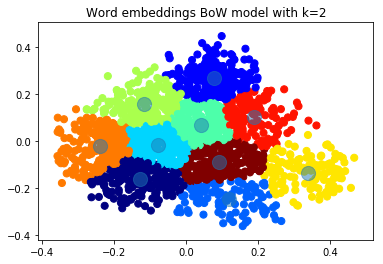

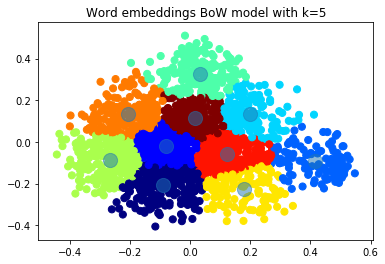

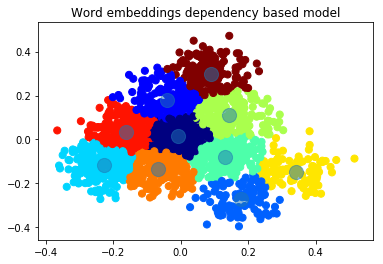

In [76]:

noun_file = '2000_nouns_sorted.txt'
nouns = []
with open(noun_file,'r') as j:
    for word in j:
        nouns.append(str(word.strip(' ').strip('\n')))
        
#Find the word embeddings for the 2000 nouns
X_bow2 = []
X_bow5 = []
X_dep = []
for word in nouns:
    try:
        X_bow2.append(bow2[word])
        X_bow5.append(bow5[word])
        X_dep.append(dep[word])
    except:
        next

#Normalize the word vectors
for i in range(0,len(X_bow2)):
    X_bow2[i] = X_bow2[i] / np.linalg.norm(X_bow2[i])
    X_bow5[i] = X_bow5[i] / np.linalg.norm(X_bow5[i])
    X_dep[i] = X_dep[i] / np.linalg.norm(X_dep[i])
        
#First we apply PCA
pca = PCA(n_components=2)
X_bow2_pca = pca.fit_transform(X_bow2)
X_bow5_pca = pca.fit_transform(X_bow5)
X_dep_pca = pca.fit_transform(X_dep)

#Now we cluster the word embeddings that are reduced to 2D using PCA
kmeans_bow2 = KMeans(n_clusters=10,random_state=0).fit(X_bow2_pca)
kmeans_bow5 = KMeans(n_clusters=10,random_state=0).fit(X_bow5_pca)
kmeans_dep = KMeans(n_clusters=10,random_state=0).fit(X_dep_pca)

kmeans_predictions_bow2 = kmeans_bow2.predict(X_bow2_pca)
kmeans_predictions_bow5 = kmeans_bow5.predict(X_bow5_pca)
kmeans_predictions_dep = kmeans_dep.predict(X_dep_pca)

#Plot the results of the Kmeans algorithm (source: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
plt.scatter(X_bow2_pca[:, 0], X_bow2_pca[:, 1], c=kmeans_predictions_bow2, s=50, cmap='jet')
centers_bow2 = kmeans_bow2.cluster_centers_
plt.scatter(centers_bow2[:, 0], centers_bow2[:, 1], s=200, alpha=0.5)
plt.title("Word embeddings BoW model with k=2")
plt.show()

plt.scatter(X_bow5_pca[:, 0], X_bow5_pca[:, 1], c=kmeans_predictions_bow5, s=50, cmap='jet')
centers_bow5 = kmeans_bow5.cluster_centers_
plt.scatter(centers_bow5[:, 0], centers_bow5[:, 1], s=200, alpha=0.5)
plt.title("Word embeddings BoW model with k=5")
plt.show()

plt.scatter(X_dep_pca[:, 0], X_dep_pca[:, 1], c=kmeans_predictions_dep, s=50, cmap='jet')
centers_dep = kmeans_dep.cluster_centers_
plt.scatter(centers_dep[:, 0], centers_dep[:, 1], s=200, alpha=0.5)
plt.title("Word embeddings dependency based model")
plt.show()


In [77]:
#Here we cluster the original data without reducing the dimensionality
noun_file = '2000_nouns_sorted.txt'
nouns = []
with open(noun_file,'r') as j:
    for word in j:
        nouns.append(str(word.strip(' ').strip('\n')))
        
#Find the word embeddings for the 2000 nouns
X_bow2 = []
X_bow5 = []
X_dep = []
for word in nouns:
    try:
        X_bow2.append(bow2[word])
        X_bow5.append(bow5[word])
        X_dep.append(dep[word])
    except:
        next

#Normalize the word vectors

for i in range(0,len(X_bow2)):
    X_bow2[i] = X_bow2[i] / np.linalg.norm(X_bow2[i])
    X_bow5[i] = X_bow5[i] / np.linalg.norm(X_bow5[i])
    X_dep[i] = X_dep[i] / np.linalg.norm(X_dep[i])


no_of_clusters = 250

kmeans_bow2_large = KMeans(n_clusters=no_of_clusters,random_state=1).fit(X_bow2)
kmeans_bow5_large = KMeans(n_clusters=no_of_clusters,random_state=1).fit(X_bow5)
kmeans_dep_large = KMeans(n_clusters=no_of_clusters,random_state=1).fit(X_dep)

kmeans_predictions_bow2_large = kmeans_bow2_large.predict(X_bow2)
kmeans_predictions_bow5_large = kmeans_bow5_large.predict(X_bow5)
kmeans_predictions_dep_large = kmeans_dep_large.predict(X_dep)

labels_bow2_large = kmeans_bow2_large.labels_
labels_bow5_large = kmeans_bow5_large.labels_
labels_dep_large = kmeans_dep_large.labels_

cluster_centers_bow2_large = kmeans_bow2_large.cluster_centers_
cluster_centers_bow5_large = kmeans_bow5_large.cluster_centers_
cluster_centers_dep_large = kmeans_dep_large.cluster_centers_

In [80]:
#In order to analyze the clusters, we print for every method a random cluster
x = random.randint(0, no_of_clusters)
from collections import Counter

bow2_counter = Counter(labels_bow2_large)

count = 0
for key,value in bow2_counter.items():
    if value == 1:
        count += 1
print("Number of clusters with no words (except for the centroid) assigned to it: ", count)
print("\n")

print("BOW2")
for i in range(0,len(labels_bow2_large)):
    if labels_bow2_large[i] == x:
        print(nouns[i])
print("\n")
print("BOW5")
for i in range(0,len(labels_bow5_large)):
    if labels_bow5_large[i] == x:
        print(nouns[i])
print('\n')
print("DEP")
for i in range(0,len(labels_dep_large)):
    if labels_dep_large[i] == x:
        print(nouns[i])

Number of clusters with no words (except for the centroid) assigned to it:  0


BOW2
captain
command
commander
headline
lead
range
sequence


BOW5
ocean
offence
region
vote


DEP
apartment
cottage
hostility
hour
pair
rest
viewer
